In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
import hydra
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from omegaconf import OmegaConf

root = os.path.abspath(os.path.join(os.path.dirname("__file__"), '../../'))
sys.path.append(root)

from src.models.predictor.seg_pytorch import Predictor
from src.data.generator.seg_pytorch.build import make_dataloader

# Preperation

In [3]:
hydra.core.global_hydra.GlobalHydra.instance().clear()

In [4]:
with initialize(config_path="../../configs"):
    
    model_folder = 'cityscapes/20201013_10_41_53'
    config_name = 'test'

    cfg = compose(overrides=[f'data=seg_pytorch', 
                             f'MODEL_PATH=models/{model_folder}/',
                             f'test=seg_pytorch'], config_name=config_name)
    
    model_cfg = compose(overrides=[f'data=seg_pytorch', 
                            '+model=seg_pytorch/hardnet',], config_name=config_name)
print(cfg)

/home/fujisaki/.pyenv/versions/3.7.2/envs/BaseModel/lib/python3.7/site-packages/omegaconf/omegaconf.py:579: UserWarning: update() merge flag is is not specified, defaulting to False.
For more details, see https://github.com/omry/omegaconf/issues/367
  stacklevel=1,
/home/fujisaki/.pyenv/versions/3.7.2/envs/BaseModel/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive data/seg_pytorch.yaml in file:///home/fujisaki/Works/BaseModel/configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)
/home/fujisaki/.pyenv/versions/3.7.2/envs/BaseModel/lib/python3.7/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive test/seg_pytorch.yaml in file:///home/fujisaki/Works/BaseModel/configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)


{'FRAMEWORK': 'pytorch', 'TASK': 'keypoint', 'MODEL_PATH': 'models/cityscapes/20201013_10_41_53/', 'TEST_ID': 'test', 'DATA': {'DATA_ID': 'cityscapes', 'SPLIT_ID': 'split01', 'DATASET': 'Cityscapes', 'CLASS_NUM': 19, 'N_FOLD': 1, 'path': '/workspace/TOYOTA/Cityscapes/'}, 'TEST': {'BATCH_SIZE': 1}, 'SYSTEM': {'DEVICE': 'GPU', 'GPUS': 0, 'SEED': False, 'NUM_WORKERS': 4, 'CUDNN': {'ENABLED': True, 'BENCHMARK': True, 'DETERMINISTIC': False}}}


# Prediction

In [5]:
%cd ../../
data_path = './data/demo_seg_pytorch/split/demo_split.pkl'
data = make_dataloader(cfg, 'val', data_path=data_path)

/home/fujisaki/Works/BaseModel
Found 16 val images


### Prepare Predictor

In [6]:
predictor = Predictor(cfg, model_cfg)

Parameters: 4119257


#### __Run Prediction__

In [7]:
print('num of data : ', len(data.dataset))
df = predictor.predict(data)

num of data :  16


16it [00:07,  2.13it/s]

Total Frame Rate = 2.92 fps
Overall Acc: 	 0.9398711505019909
Mean Acc : 	 0.6909786576632884
FreqW Acc : 	 0.89215274655689
Mean IoU : 	 0.6090715652817934
0 0.9827657320146606
1 0.8412719193537208
2 0.8326381078448813
3 0.4271621636322101
4 0.52030536559162
5 0.5290993143703061
6 0.5163920174642119
7 0.6982819250477244
8 0.9015362171329412
9 0.11324626988788217
10 0.9032562583918877
11 0.667733402330704
12 0.48314266690878277
13 0.9324794165715872
14 0.8808473670141673
15 0.15934130470530197
16 0.0
17 0.6535885167464115
18 0.5292717753450737


In [8]:
pred = np.squeeze(np.squeeze(np.array(df.loc[0, 'Array']), 0), 0)
print('Shape of output : ', pred.shape)

conf_mat = np.squeeze(np.array(df.loc[0, 'Confmat']), 0)
print('Shape of confusion matrix : ', conf_mat.shape)

Shape of output :  (1024, 2048)
Shape of confusion matrix :  (19, 2, 2)


#### __Calculating evalution score__

In [9]:
class_names = [
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

In [10]:
fs, ious, precisions, recalls = [], [], [], []

for idx, cm in enumerate(conf_mat):

    TN = cm[0,0]
    FP = cm[0,1] 
    FN = cm[1,0] 
    TP = cm[1,1]

    # F score
    Fscore = (2 * TP) / (2 * TP + FP + FN)

    # IoU
    IoU = TP / (TP + FP + FN)

    # Precision
    Precision = TP / (TP + FP)

    # Recall
    Recall = TP / (TP + FN)
    
    fs.append(Fscore)
    ious.append(IoU)
    precisions.append(Precision)
    recalls.append(Recall)

pd.DataFrame(list(zip(fs, ious, precisions, recalls)),
                     columns=['Fscore', 'IoU', 'Precision', 'Recall'],index=class_names)

/home/fujisaki/.pyenv/versions/3.7.2/envs/BaseModel/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in long_scalars
/home/fujisaki/.pyenv/versions/3.7.2/envs/BaseModel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


,Fscore,IoU,Precision,Recall
road,0.916405,0.845708,0.851088,0.992580
sidewalk,0.712056,0.552862,0.742512,0.683999
building,0.544614,0.374206,0.407675,0.820080
wall,0.000000,0.000000,0.000000,NaN
fence,0.562616,0.391417,0.607655,0.523793
pole,0.423902,0.268957,0.614114,0.323655
traffic_light,0.621020,0.450347,0.754219,0.527806
traffic_sign,0.468252,0.305698,0.313967,0.920679
vegetation,0.935111,0.878131,0.927193,0.943166
terrain,0.000000,0.000000,0.000000,0.000000


#### __Predict Single Image__

In [11]:
# raw image
img_path = df.loc[:, 'ImgPath'][10]

# convert to array
img_arr = np.array(Image.open(img_path))

# predicted image
predicted = predictor.predict_image(img_arr).squeeze(0)
color_map = torch.load('./data/demo_seg_pytorch/split/color_map.pkl')

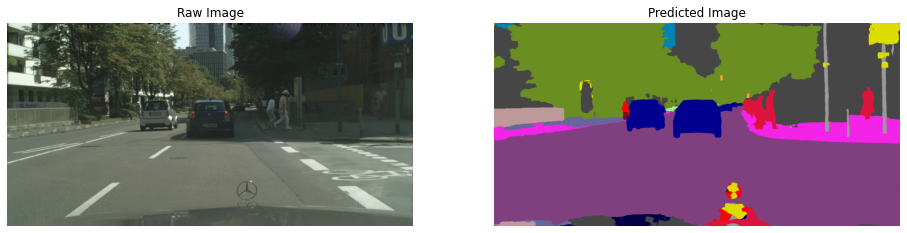

In [12]:
plt.figure(figsize=(16,12))

plt.subplot(121) 
plt.imshow(Image.open(img_path)) 
plt.title('Raw Image')
plt.axis("off")

plt.subplot(122) 
plt.imshow(color_map[predicted])
plt.title('Predicted Image')
plt.axis("off")

plt.show()
plt.close()